# Clase#5 - Ecuaciones Diferenciales Ordinarias

<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Lorenz_attractor_yb.svg" height=400/>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Módulo para resolver ecuaciones diferenciales ordinarias
from scipy.integrate import odeint

# Importar la biblioteca de álgebra lineal de SciPy
from scipy import linalg as la

# Vectores y valores propios

### Problemas de valores y vectores propios

El problema de los valores y vectores propios se refiere a la solución del problema $A\vec{v}=\lambda\vec{v}$.

Referencia documental:

- Implementación en SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html
- Implementación en NumPy: https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

Por supuesto que pudiera pensarse en diagonalizar la matriz para simplificar el problema pero esto *cambia los valores propios* cosa que no es deseable.

En su lugar se reagrupan los terminos para tener 

$\left(A-\lambda I\right)\vec{v}=0$

lo cual permite un mejor análisis. Obviando la solución trivial $\vec{v}=0$ entonces nos enfocamos en el determinado por el polinómio característico:

$\det\left(A-\lambda I\right)=0$.

Las raíces de este polinomio permiten conocer los valores propios $\lambda$ y a partir de ellos los espacios de vectores propios asociados que conforman el espacio nulo de la matriz resultante

$\left(A-\lambda I\right)\vec{v}=0$.

En el módulo ```linalg``` de ```scipy``` se encuentran algunas funciones que permiten calcular los vectores y valores propios de forma eficiente (usando rutinas implementadas en la biblioteca ```LAPACK``` de FORTRAN).

función                      | Descripción
-----------------------------|--------------------------------------
```scipy.linalg.eigvals```   | Calcula los valores propios de un problema ordinario o generalizado (ver ejemplos debajo) de valores propios.
```scipy.linalg.eig```       | Calcula los valores propios como el anterior pero también brinda los vectores propios asociados (contiguos si vienen en pares).
```scipy.linalg.eigh```      | Realiza la misma función que el anterior pero con la particularidad de que está optimizado para matrices simétricas. La implementación en ```LAPACK``` utiliza una descomposición $QR$.
```scipy.linalg.eigh_tridiagonal``` |  Resuelve el problema para matrices simétricas tri-diagonales (interesante en el área de las ecuaciones diferenciales en derivadas parciales).

#### **Demo #1:** 

Veamos un ejemplo de un problema ordinario donde se tiene una matriz $A=\begin{bmatrix}
0 & -1\\
1 & 0
\end{bmatrix}$.

In [2]:
A = np.array([[0.0, -1.0], [1.0, 0.0]])
print("Valores propios ", la.eigvals(A))

Valores propios  [0.+1.j 0.-1.j]


Al calcular los valores propios, estos son números complejos. 

*Como posible aplicación se puede decir que sus vectores propios asociados definen transformaciones rotatorias en el espacio.*

#### **Demo #2:** 

Si calculamos un problema general donde definimos otra transformación lineal $B=\begin{bmatrix} 0 & 1 \\ 1 & 1\end{bmatrix}$ entonces se tiene el siguiente problema

$A\vec{v}=\lambda B\vec{v}$,

$\left(A-\lambda B\right)\vec{v}=0$.
En el siguiente ejemplo se muestra como resolver este problema.

In [3]:
B = np.array([[0.0, 1.0], [1.0, 1.0]])
print("Valores propios ", la.eigvals(A, B))

Valores propios  [ 1.+0.j -1.+0.j]


En este caso los valores propios son números reales.

#### **Demo #3:** 

Supongamos ahora que queremos calcular además los vectores propios asociados. Entonces podemos utilizar la función general ```scipy.linalg.eig```:

In [4]:
A2 = np.array([[1, -1], [2, 4]])

# Calculando valores y vectores propios
e = la.eig(A2)

print("Valores propios:", e[0])
print("Vectores propios normalizados:\n", e[1] / la.norm(e[1]))

Valores propios: [2.+0.j 3.+0.j]
Vectores propios normalizados:
 [[-0.5         0.31622777]
 [ 0.5        -0.63245553]]


En este acaso se devuelve un array con dos elementos ```[valores propios, vectores propios]```. 

En el caso anterior el polinomio característico queda 

$\lambda^2 - 5 \lambda + 6 = 0$ 

con soluciones $\lambda_1 = 3$ y $\lambda_2 = 2$.

Si se calculan analíticamente los espacios de vectores propios se obtiene 

$\vec{v}_{\lambda_1} = 
\begin{bmatrix}
-\frac{1}{2} \\
\frac{1}{2}
\end{bmatrix}$ y 
$\vec{v}_{\lambda_2} = 
\begin{bmatrix}
\frac{1}{3} \\
-\frac{2}{3}
\end{bmatrix}$.

Es importante notar que la función ```scipy.linalg.eig``` tiene los parámetros ```left``` y ```right```. Esto significa que

*   Si ```left=True``` entonces la matriz de vectores propios $S$ dada será de acuerdo a $A = S \mathcal{Λ} S^{-1}$.
*   Si ```right=True``` entonces la matriz de vectores propios $S$ dada será de acuerdo a $A = S^{-1} \mathcal{Λ} S$.

La diferencia que se muestra en el segundo vector está dada por aproximaciones numéricas.

# Ecuaciones Diferenciales Ordinarias y Optimización

## Presentación de el método odeint

Para la resolución de ecuaciones diferenciales ordinarias existe la función ```odeint``` que está implementada en el módulo ```scipy.integrate```.

Esta constituye una interfaz simple que empaqueta las funciones de la biblioteca [ODEPACK](https://computing.llnl.gov/projects/odepack) que se encuentra implementada en lenguaje FORTRAN. Los métodos numéricos utilizados forman parte del paquete llamado LSODE.

In [5]:
from scipy.integrate import odeint

Expliquemos como se utiliza a través de los siguientes ejemplos

## Modelo SIR (Simulación de epidemias)

El modelo SIR es utilizado en la simulación matemática de epidemias. Sus siglas quieren decir en lenguaje inglés 
*   población suceptible (S) que son los individuos sin inmunidad que pudieran contrar el virus,
*   infestada (I) que son aquellos que ya lo han contraido y
*   recuperada (R) para aquellos que ya han contraido el virus y son inmunes. 

La población total se puede expresar como $N = S + I + R$.

El siguiente sistema de ecuaciones de es la más general de las variaciones que existen de este modelo:

$
\begin{align}
\dfrac{dS}{dt} &= -β S I\\
\dfrac{dI}{dt} &= β S I - \gamma I\\
\dfrac{dR}{dt} &= \gamma I
\end{align}
$

## Simulación de epidema del COVID en Perú desde 2020.04 hasta 2022.01

Los datos fueron obtenidos de la siguiente fuente:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

### Importación de los datos

Primero importamos el módulo de python "covid19dh".

In [6]:
from covid19dh import covid19

Luego incorporamos el ```data frame``` de la biblioteca ```Pandas``` a nuestro proyecto y obtenemos los datos referentes a las poblaciones suseptibles, infectadas y recuperadas.

In [7]:
df, _ = covid19("Peru", verbose=False)

# interpolating necessary data
for c in ["recovered", "population", "confirmed"]:
    df[c] = df[c].interpolate(limit_direction="both")

S_real = ((df["population"] - df["confirmed"]) / df["population"]).to_numpy()
I_real = ((df["confirmed"] - df["recovered"]) / df["population"]).to_numpy()
R_real = ((df["recovered"]) / df["population"]).to_numpy()

Mostremos los datos en gráficas:

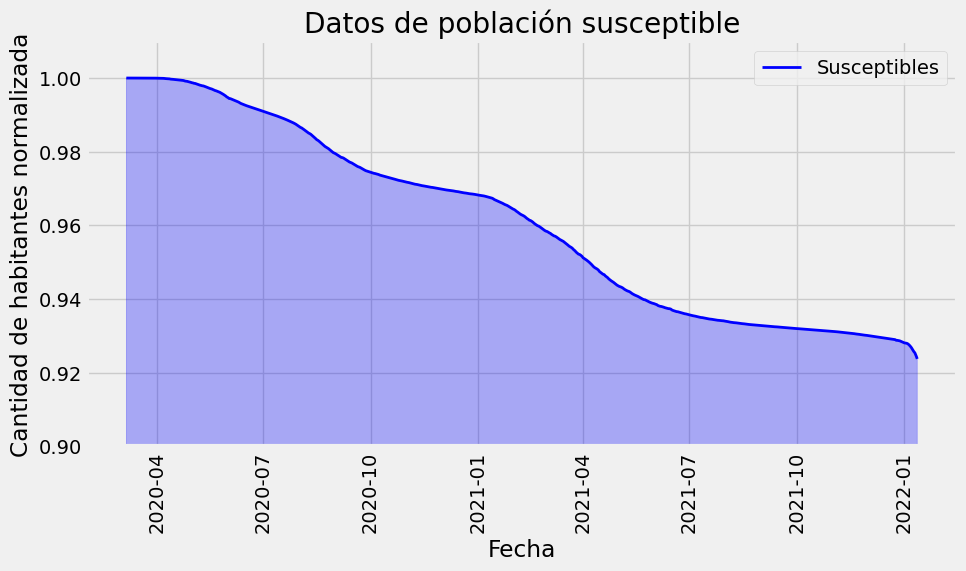

In [8]:
with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(10, 5))
    plt.fill_between(df["date"], S_real, color="b", alpha=0.3)
    plt.plot(df["date"], S_real, "-b", label="Susceptibles", linewidth=2.0)
    plt.xticks(rotation=90)
    plt.ylim([0.9, 1.01])
    plt.ylabel("Cantidad de habitantes normalizada")
    plt.xlabel("Fecha")
    plt.legend()
    plt.title("Datos de población susceptible")
    plt.show()
    plt.close()

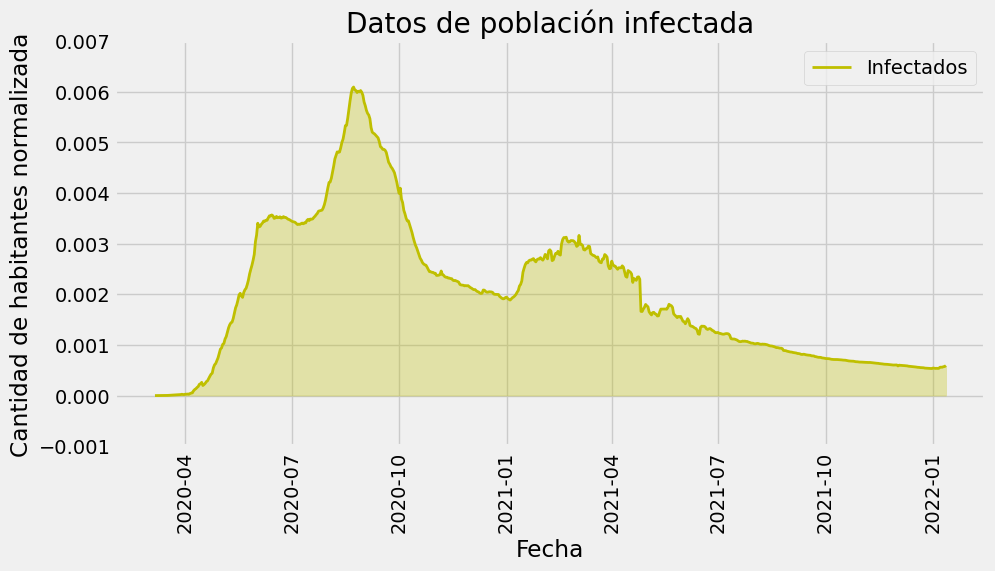

In [9]:
with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(10, 5))
    plt.fill_between(df["date"], I_real, color="y", alpha=0.3)
    plt.plot(df["date"], I_real, "-y", label="Infectados", linewidth=2.0)
    plt.xticks(rotation=90)
    plt.ylim([-0.001, 0.007])
    plt.ylabel("Cantidad de habitantes normalizada")
    plt.xlabel("Fecha")
    plt.legend()
    plt.title("Datos de población infectada")
    plt.show()
    plt.close()

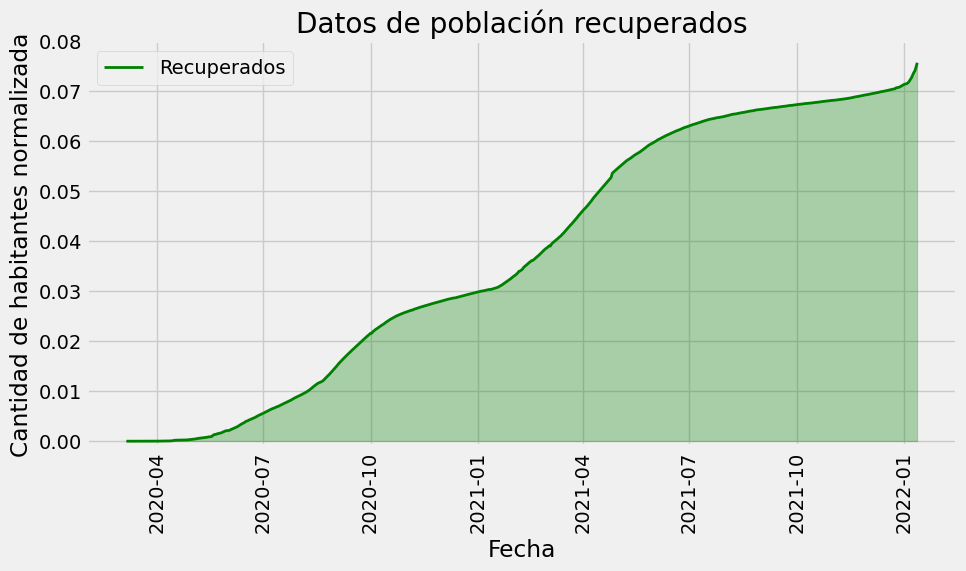

In [10]:
with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(10, 5))
    plt.fill_between(df["date"], R_real, color="g", alpha=0.3)
    plt.plot(df["date"], R_real, "-g", label="Recuperados", linewidth=2.0)
    plt.xticks(rotation=90)
    plt.ylim([-0.001, 0.08])
    plt.ylabel("Cantidad de habitantes normalizada")
    plt.xlabel("Fecha")
    plt.legend()
    plt.title("Datos de población recuperados")
    plt.show()
    plt.close()

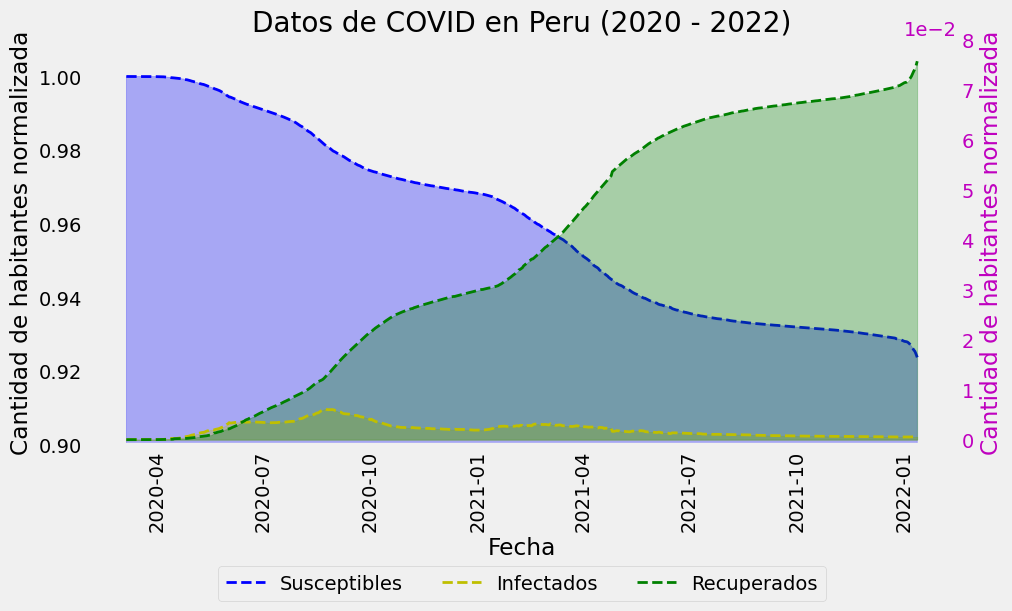

In [11]:
with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.subplots(1, 1)
    ax.fill_between(df["date"], S_real, color="b", alpha=0.3)
    ax.plot(df["date"], S_real, "--b", label="Susceptibles", linewidth=2.0)
    ax.set_ylabel("Cantidad de habitantes normalizada")
    plt.xticks(rotation=90)
    plt.ylim([0.9, 1.01])
    ax.grid()
    ax.set_xlabel("Fecha")
    ax2 = ax.twinx()

    ax2.fill_between(df["date"], I_real, color="y", alpha=0.3)
    ax2.plot(df["date"], I_real, "--y", label="Infectados", linewidth=2.0)

    ax2.fill_between(df["date"], R_real, color="g", alpha=0.3)
    ax2.plot(df["date"], R_real, "--g", label="Recuperados", linewidth=2.0)

    ax2.tick_params(axis="y", labelcolor="m")
    ax2.set_ylabel("Cantidad de habitantes normalizada", color="m")
    ax2.ticklabel_format(useOffset=False, style="sci", axis="y", scilimits=(0, 0))
    ax2.grid()
    plt.ylim([-0.001, 0.08])
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()

    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.41))
    ax.set_title("Datos de COVID en Peru (2020 - 2022)")
    plt.show()
    plt.close()

### Calculando parámetros 

Calcular los parámetros del modelo $\beta$ y $\gamma$ que representan la tasa de infección y la tasa de recuperación respectivamente.

Calculemos una aproximación a las derivadas de las poblaciones susceptibles y recuperados.

In [12]:
dsdt = np.diff(S_real)
drdt = np.diff(R_real)

Despejando en la primera y segunda ecuación los parámetros tenemos que 

$
\begin{align}
\beta &= - \frac{\dfrac{d S}{dt}}{ S I}\\
\gamma &= \frac{\dfrac{dR}{dt}}{I}
\end{align}
$

In [13]:
beta_real = -dsdt / S_real[1:] / I_real[1:]
gamma_real = drdt / I_real[1:]

Ploteando el desarrollo de los parámetros en el tiempo

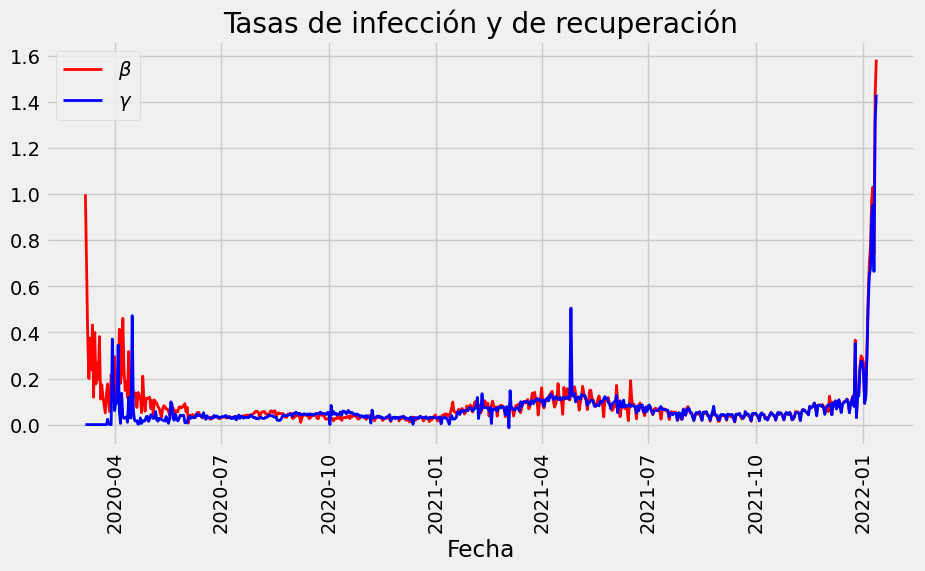

In [14]:
with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(df["date"].iloc[1:], beta_real, "-r", label=r"$\beta$", linewidth=2.0)
    plt.plot(df["date"].iloc[1:], gamma_real, "-b", label=r"$\gamma$", linewidth=2.0)
    plt.xticks(rotation=90)
    # plt.ylim([-0.001, 0.08])
    plt.xlabel("Fecha")
    plt.legend()
    plt.title("Tasas de infección y de recuperación")
    plt.show()
    plt.close()

### Resolución del modelo

Primero creamos una función que va a representar nuestro sistema de ecuaciones. Recibe como paráemtros de entrada:

*   ```y```: Vector de la solución obtenida en la iteración anterior.
*   ```t```: Valor temporal correspondiente a la iteración actual.
*   ```args```: Los argumentos que necesite el modelo para su ejecución separados por coma (cada uno un parámetro de la función).

Esta función retorna los valores correspondientes a la derivada de cada una de las variables del sistema. En la implementación siguiente estos valores fueron asignados a la variable ```dy```.

In [15]:
def sir(y, t, beta, gamma):
    # Creando el vector resultante vacío de la misma forma que y.
    dy = np.empty_like(y)

    # Por cada variable calcular la derivada y asignarla a y.
    dy[0] = -beta * y[0] * y[1]
    dy[1] = beta * y[0] * y[1] - gamma * y[1]
    dy[2] = gamma * y[1]

    return dy

Para resolver el problema utilizamos la función ```scipy.integrate.odeint``` la cual recibe los siguientes parámetros:

*   ```func```: Función que representa al sistema de ecuaciones diferenciales ordinarias.
*   ```y0```: Vector de condiciones iniciales.
*   ```t```: Vector que representa el intervalo de tiempo por el cual el método iterará.
*   ```args```: Tupla con los valores del resto de los parámetros de la función del sistema en ese mismo orden.

Tomemos $\beta$ y $\gamma$ como el promedio de sus valores por simplicidad

In [16]:
beta = np.mean(beta_real)
gamma = np.mean(gamma_real)

Ahora hagamos una simulación tomando como condicoines iniciales los valores de S, I y R correspondientes al día número $30$ de los datos (antes no hay infectados).

In [17]:
# Initial state
init_day = 30

init_state = np.array([S_real[init_day], I_real[init_day], R_real[init_day]])
print(init_state)

t = np.arange(len(S_real) - init_day)

state = odeint(sir, init_state, t, (beta, gamma))

S_model, I_model, R_model = state.T

[9.99919942e-01 4.88914153e-05 3.11667142e-05]


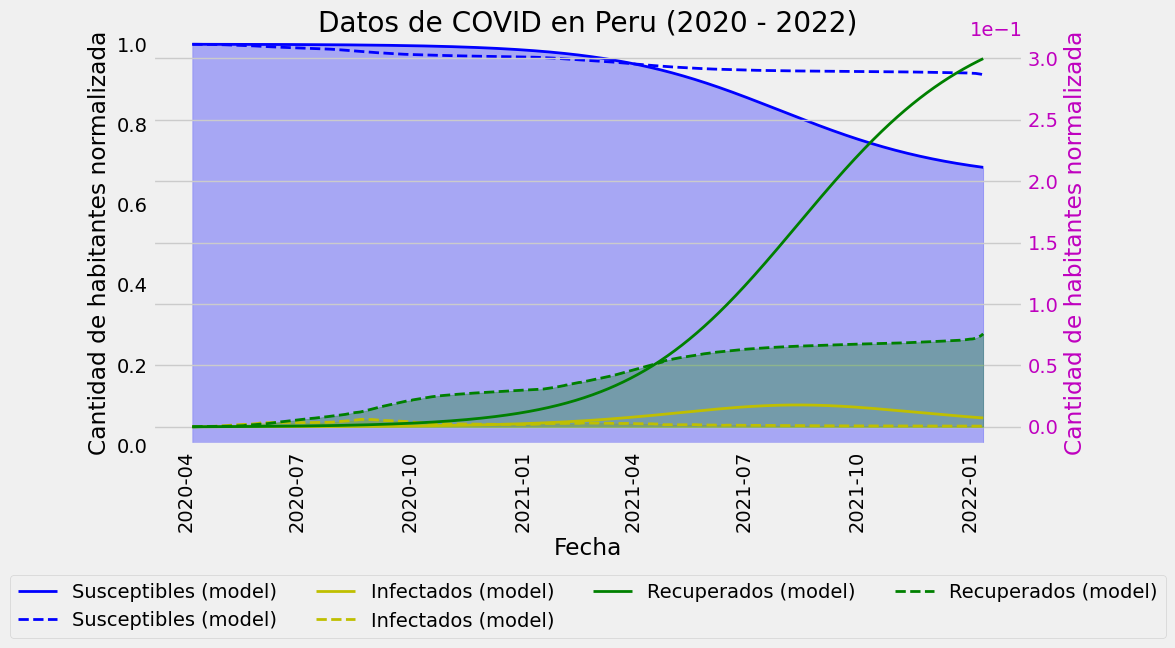

In [18]:
with plt.style.context("fivethirtyeight"):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.subplots(1, 1)

    ax.fill_between(df["date"][init_day:], S_model, color="b", alpha=0.3)
    ax.plot(
        df["date"][init_day:],
        S_model,
        "-b",
        label="Susceptibles (model)",
        linewidth=2.0,
    )

    # ax.fill_between(df['date'][init_day:], S_real[init_day:], color='b', alpha=0.3)
    ax.plot(
        df["date"][init_day:],
        S_real[init_day:],
        "--b",
        label="Susceptibles (model)",
        linewidth=2.0,
    )

    ax.set_ylabel("Cantidad de habitantes normalizada")
    plt.xticks(rotation=90)
    plt.ylim([0.0, 1.01])
    ax.grid()
    ax.set_xlabel("Fecha")
    ax2 = ax.twinx()

    # ax2.fill_between(df['date'][init_day:], I_model, color='y', alpha=0.3)
    ax2.plot(
        df["date"][init_day:], I_model, "-y", label="Infectados (model)", linewidth=2.0
    )

    ax2.fill_between(df["date"][init_day:], I_real[init_day:], color="y", alpha=0.3)
    ax2.plot(
        df["date"][init_day:],
        I_real[init_day:],
        "--y",
        label="Infectados (model)",
        linewidth=2.0,
    )

    # ax2.fill_between(df['date'][init_day:], R_model, color='g', alpha=0.3)
    ax2.plot(
        df["date"][init_day:], R_model, "-g", label="Recuperados (model)", linewidth=2.0
    )

    ax2.fill_between(df["date"][init_day:], R_real[init_day:], color="g", alpha=0.3)
    ax2.plot(
        df["date"][init_day:],
        R_real[init_day:],
        "--g",
        label="Recuperados (model)",
        linewidth=2.0,
    )

    ax2.tick_params(axis="y", labelcolor="m")
    ax2.set_ylabel("Cantidad de habitantes normalizada", color="m")
    ax2.ticklabel_format(useOffset=False, style="sci", axis="y", scilimits=(0, 0))
    ax2.grid()
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()

    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax.legend(lines, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.5))
    ax.set_title("Datos de COVID en Peru (2020 - 2022)")
    plt.grid()
    plt.show()
    plt.close()

## Sistema orbital de Kepler

El astrónomo y matemático alemán Johannes Kepler planteo leyes que describen el movimiento de un objeto de tamaño planetario alrededor de un sol masivo. Estas expresan la atracción gravitacional que el sol ejerce sobre el planeta.

Sean $y_1$ y $y_2$ las coordenadas cartesianes centradas en el sol que especifican la posición del planeta en un instante de tiempo $t$. También $y_3$ y $y_4$ denotan las componentes de velocidad en la dirección de $y_1$ y $y_2$. Si $M$ denota la masa del sol, $\gamma$ la constante gravitatoria y $m$ la masa del planeta, entoncesla fuerza de atracción que el sol ejerce al planeta tiene una magnitud de 

$\frac{\gamma M m}{y_1^2 + y_2^2}$.

Luego, la fuerza de atracción se puede escribir como $-\gamma M y_1 (y_1^2 + y_2^2)^{-3/2}$.

El sistema de ecuaciones diferenciales ordinarias queda

$
\begin{align}
\dfrac{d y_1}{dx} &= y3\\
\dfrac{d y_2}{dx} &= y4\\
\dfrac{d y_3}{dx} &= -\frac{\gamma M y_1}{(y_1^2 + y_2^2)^{-3/2}}\\
\dfrac{d y_4}{dx} &= -\frac{\gamma M y_2}{(y_1^2 + y_2^2)^{-3/2}}
\end{align}
$

que escalando por el factor $\gamma M$ se obtiene

$
\begin{align}
\dfrac{d y_1}{dx} &= y3\\
\dfrac{d y_2}{dx} &= y4\\
\dfrac{d y_3}{dx} &= -\frac{y_1}{(y_1^2 + y_2^2)^{-3/2}}\\
\dfrac{d y_4}{dx} &= -\frac{y_2}{(y_1^2 + y_2^2)^{-3/2}}
\end{align}
$

Hagamos una implementación del mismo:

In [19]:
import matplotlib.animation as animation
from pylab import *

#%matplotlib widget

In [20]:
# Sistema de ecuaciones de Kepler
def KeplerSystem(state, t):
    y1, y2, y3, y4 = state
    d_y3 = -1 * y1 / np.power(y1**2.0 + y2**2.0, 3.0 / 2.0)
    d_y4 = -1 * y2 / np.power(y1**2.0 + y2**2.0, 3.0 / 2.0)
    return [y3, y4, d_y3, d_y4]

In [21]:
# tiempo \delta t en n pasos.
t = np.arange(0, 20, 0.1)

# ---- planet1 ----
# Condiciones iniciales del sistema de ODEs
init_state_planet1 = [0.0, 2.0, -0.3, 0.3]
# Resolucion del sistema usando interface LSODA de ODEPACK, Fortran
state_planet1 = odeint(KeplerSystem, init_state_planet1, t)

# ---- planet2 ----
# Condiciones iniciales del sistema de ODEs
init_state_planet2 = [-0.3, -1.5, 0.4, 0.01]
# Resolucion del sistema usando interface LSODA de ODEPACK, Fortran
state_planet2 = odeint(KeplerSystem, init_state_planet2, t)

# Creando la figura
fig = plt.figure()


def animate(i):
    plt.clf()  # Esta instruccion borra todo lo que hay en la imagen
    plt.title("Leyes de Kepler")
    plt.grid()
    plt.xlim([-1.5, 1.5])
    plt.ylim([-2.0, 3.3])

    # Ploteando orbitas de planetas
    plt.plot(state_planet1[0:i, 0], state_planet1[0:i, 1], "b--", linewidth=0.5)
    plt.plot(state_planet2[0:i, 0], state_planet2[0:i, 1], "b--", linewidth=0.5)

    # Ploteando los planetas
    plt.scatter(
        [0.0, state_planet1[i, 0], state_planet2[i, 0]],
        [0.0, state_planet1[i, 1], state_planet2[i, 1]],
        c=["y", "g", "m"],
        s=[500.0, 100.0, 100.0],
    )

    # Ploteando vector de velocidad
    ax = plt.axes()
    ax.arrow(
        state_planet1[i, 0],
        state_planet1[i, 1],
        state_planet1[i, 2] / 1.5,
        state_planet1[i, 3] / 1.5,
        head_width=0.05,
        head_length=np.sqrt(state_planet1[i, 2] ** 2 + state_planet1[i, 3] ** 2) / 10.0,
        fc="k",
        ec="k",
        overhang=2,
    )
    ax.arrow(
        state_planet2[i, 0],
        state_planet2[i, 1],
        state_planet2[i, 2] / 1.5,
        state_planet2[i, 3] / 1.5,
        head_width=0.05,
        head_length=np.sqrt(state_planet2[i, 2] ** 2 + state_planet2[i, 3] ** 2) / 10.0,
        fc="k",
        ec="k",
        overhang=2,
    )


# Correr la animacion definida en la funcion animate
anim = animation.FuncAnimation(fig, animate, interval=40, frames=90)
anim

/tmp/ipykernel_126583/1950233733.py:66: UserWarning: You passed in an explicit save_count=10 which is being ignored in favor of frames=100.
  anim = animation.FuncAnimation(fig, animate, interval=20, frames=100, repeat=False, save_count=10)


In [22]:
plt.close(fig)

## **Ejemplo #1**: Atunes y Delfines

Supongamos que nos encontramos analizando el comportamiento de dos poblaciones que existen en un mismo ecosistema de forma ideal. Esto último quiere decir que se asume que las poblaciones no tienen contacto con otras poblaciones. 

Digamos que $A\left(t\right)$ representa la cantidad de individuos que posee una población de atunes en un timpo determinado. Por otra parte $D\left(t\right)$ representa la cantidad de delfines que pertenecen a la otra población en el mismo tiempo.


<img src="https://drive.google.com/uc?export=view&id=1E1hmcVAjmQBlxJFnKRO6hAQ9it4ASC3u" width=400 height=400>

[Imagen tomada de www.pekelandia.com](https://www.pekelandia.com/fabulas-y-moralejas/el-atun-y-el-delfin-fabula-clasica-de-esopo-con-moraleja)

Entonces su relación presa-depredador pudiera ser expresada de forma muy simple como sigue:

$
\begin{align}
\dfrac{\mathrm{d}A(t)}{\mathrm{d}t} &= \alpha A(t) - β D(t)\\
\dfrac{\mathrm{d}D(t)}{\mathrm{d}t} &= \gamma D(t)
\end{align}
$
, donde $\alpha=3.0$, $\beta=1.0$ y $\gamma=1.0$.

La primera ecuación expresa que los atunes crecerán a una velicidad igual al tamaño de la población por un coeficiente de crecimiento (en este caso $\alpha=3.0$) pero a su vez sus números decrecen de acuerdo a un coeficiente por la cantidad de delfines que existan ($\beta=1.0$).

La segunda ecuación expresa que los delfines se reproducen a una velocidad determinada por su número actual por un coeficiente ($\gamma = 1.0$).

Por supuesto que la población de delfines crecerá exponencialmente sin mostrar decadencia, pero también pudiera asumirse que el estudio es en un período de tiempo tan corto que los delfines ni los atunes mueren de causa natural.

¿Cuáles serían los valores iniciales de ambas poblaciones para garantizar que ninguna se extinga en esa área de estudio determinada?

Simulación a partir de las condiones iniciales $y_{0}=\left(3, 6\right)$:

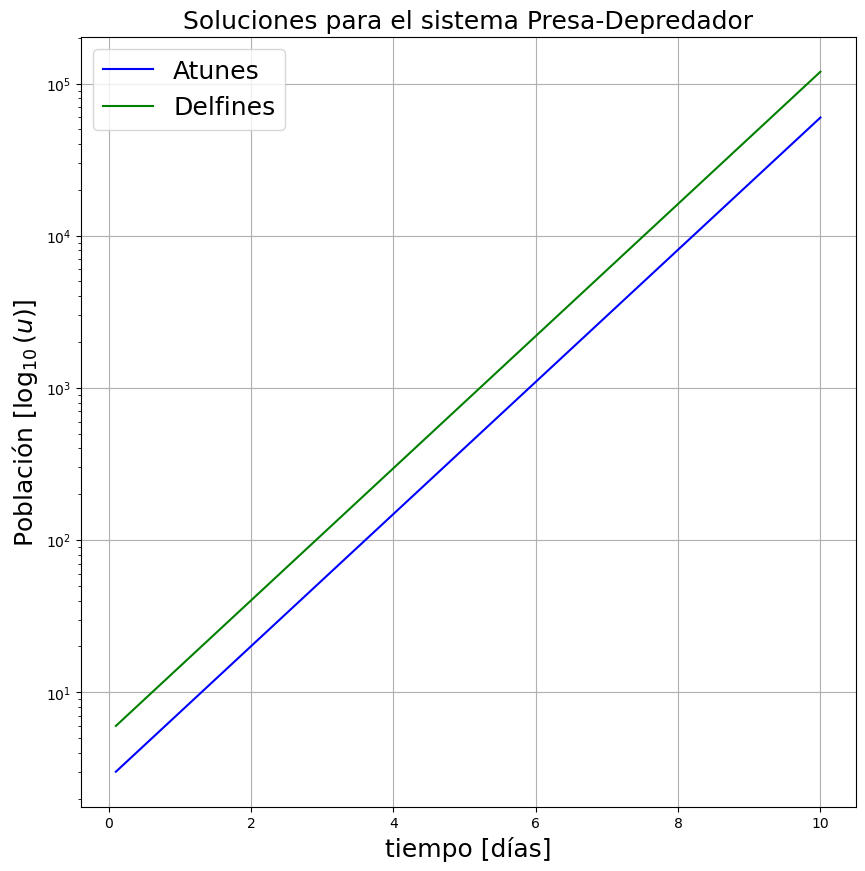

In [23]:
# Sistema de ecuaciones diferenciales ordinarias
def system_ode(y, t, alpha, beta, gamma):
    dA = alpha * y[0] - beta * y[1]
    dD = gamma * y[1]

    return [dA, dD]


# Condiciones iniciales
y0 = [3, 6]

# Intervalos de tiempo de los pasos de la simulación
t = np.linspace(0.1, 10.0, 100)

# Parámetros del modelo
alpha, beta, gamma = (3.0, 1.0, 1.0)

# Resolución del sistema de ecuaciones difereciales ordinarias (Será explicado más adelante)
sol = odeint(system_ode, y0, t, args=(alpha, beta, gamma))

# Mostrando las soluciones
plt.figure(figsize=(10, 10))
plt.semilogy(t, sol[:, 0], "-b", label="Atunes")
plt.semilogy(t, sol[:, 1], "-g", label="Delfines")
plt.grid()
plt.xlabel("tiempo [días]", fontsize=18)
plt.ylabel("Población [$\log_{10}(u)$]", fontsize=18)
plt.title("Soluciones para el sistema Presa-Depredador", fontsize=18)
plt.legend(fontsize=18)
plt.show()
plt.close()

Esta representa curvas de población estables en el tiempo como esposible también comprobar en la siguiente gráfica.

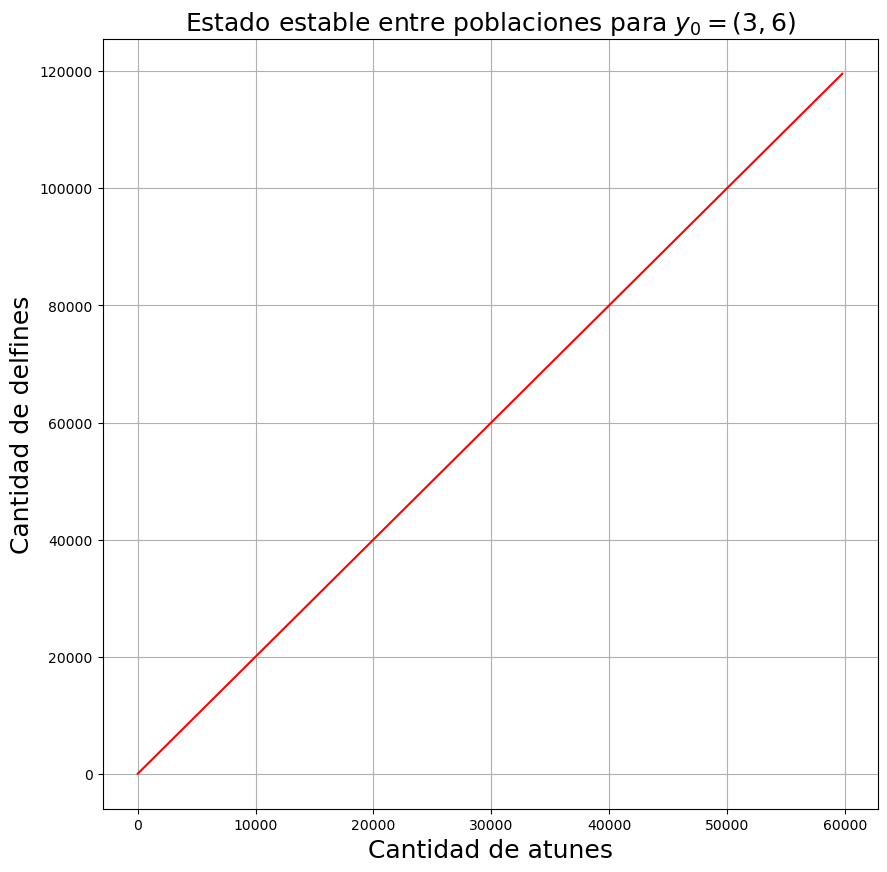

In [24]:
plt.figure(figsize=(10, 10))
plt.plot(sol[:, 0], sol[:, 1], "-r")
plt.grid()
plt.xlabel("Cantidad de atunes", fontsize=18)
plt.ylabel("Cantidad de delfines", fontsize=18)
plt.title("Estado estable entre poblaciones para $y_0 = (3, 6)$", fontsize=18)
plt.show()
plt.close()

Simulemos y grafiquemos las soluciones del sistema para diferentes condiciones iniciales. Estas condiciones iniciales serán tomadas como puntos en una rejilla $y_0 = (A(0), D(0)) = (0.0 <= A(0) <= 15)\times(0.0 <= D(0) <= 15)$ con un espaciado de 1.

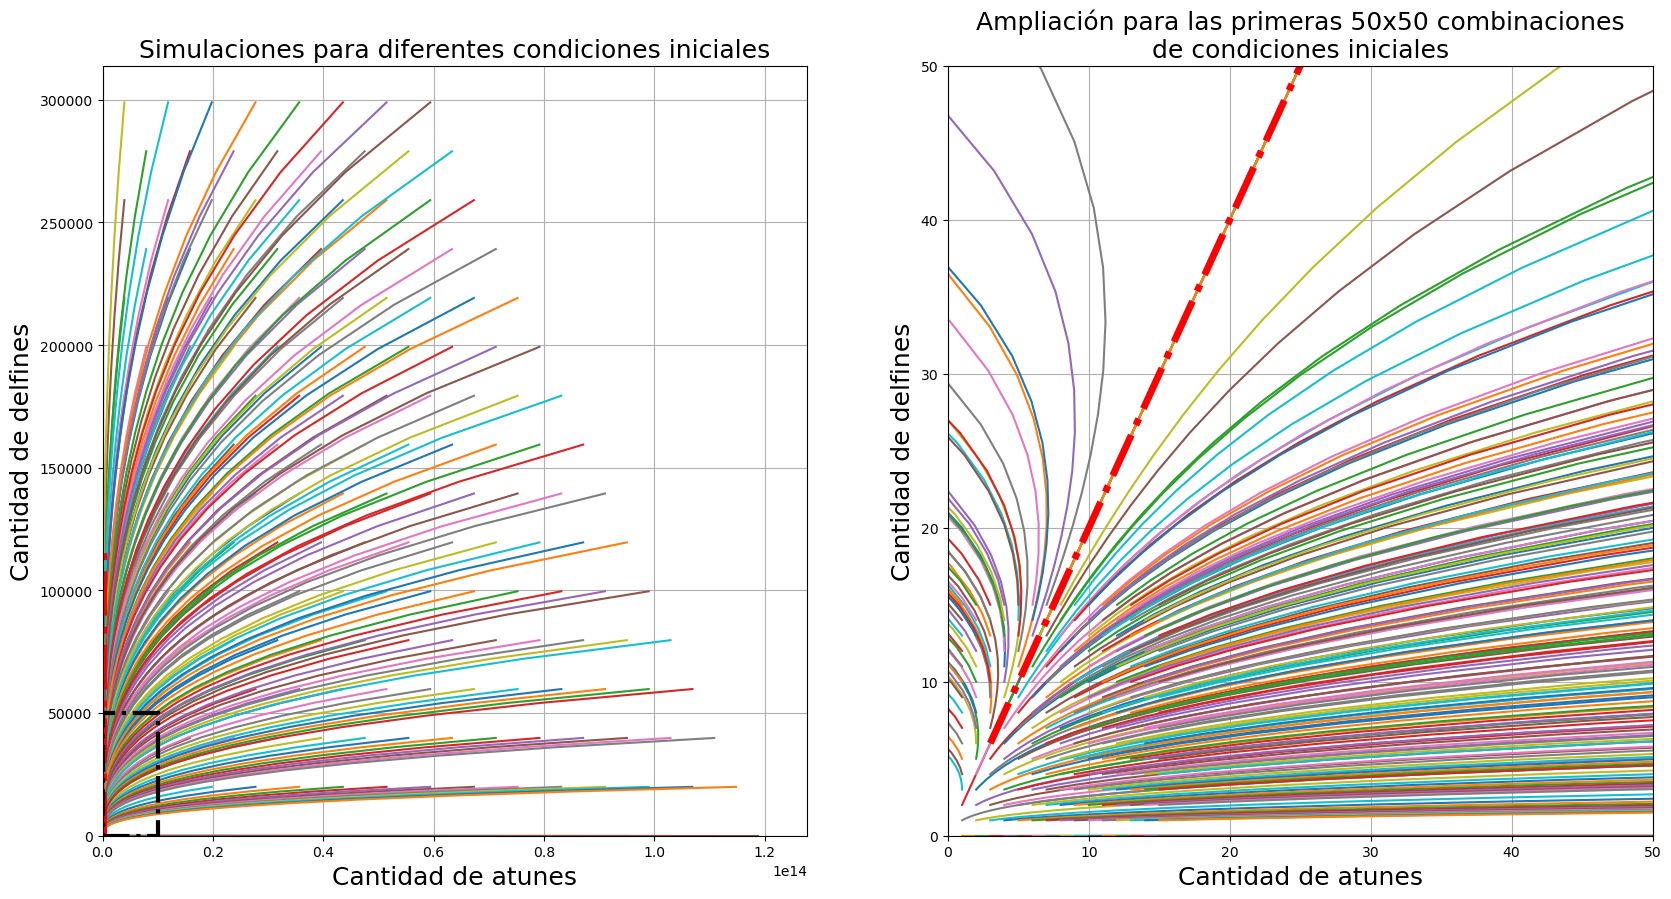

In [25]:
# Se utiliza para dibujar figuras geometricas y paths
import matplotlib.patches as patches

# Cantidades de las dos poblaciones a=atunes, d=delfines
a = np.arange(0, 16, 1)
d = np.arange(0, 16, 1)

# Rejilla de condiciones iniciales
A, D = np.meshgrid(a, d)

# Creando figura con dos gráficas horizontales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Tiempo de simulación
t = np.linspace(0.1, 10.0, 100)

# parámetros
alpha, beta, gamma = (3.0, 1.0, 1.0)

# Ejecutando una simulación por cada condición inicial en la rejilla
for i in range(D.shape[0]):
    for j in range(A.shape[1]):
        # Condición inicial actual
        y0 = [A[i, j], D[i, j]]
        # Resolución del problema
        soln = odeint(system_ode, y0, t, args=(alpha, beta, gamma))
        # Plotear en las gráficas las soluciones
        ax1.plot(soln[:, 0], soln[:, 1])
        ax2.plot(soln[:, 0], soln[:, 1])

# Ploteando ambdas gráficas
ax1.plot(sol[:, 0], sol[:, 1], "-.r", linewidth=5)
ax2.plot(sol[:, 0], sol[:, 1], "-.r", linewidth=5)

ax1.grid()
ax2.grid()

ax1.set_xlabel("Cantidad de atunes", fontsize=18)
ax1.set_ylabel("Cantidad de delfines", fontsize=18)
ax2.set_xlabel("Cantidad de atunes", fontsize=18)
ax2.set_ylabel("Cantidad de delfines", fontsize=18)

ax1.set_xlim(left=0.0)
ax1.set_ylim(bottom=0.0)
ax2.set_xlim([0.0, 50.0])
ax2.set_ylim([0.0, 50.0])

# Pintando un rectángulo
rect = patches.Rectangle(
    (0.0, 0.0),
    0.1e14,
    50000,
    linewidth=3,
    linestyle="-.",
    edgecolor="k",
    facecolor="none",
    zorder=8,
)
ax1.add_patch(rect)

ax1.set_title("Simulaciones para diferentes condiciones iniciales", fontsize=18)
ax2.set_title(
    "Ampliación para las primeras 50x50 combinaciones\nde condiciones iniciales",
    fontsize=18,
)

plt.show()
plt.close()

Calculemos sus vectores y valores propios

In [26]:
# Crear la matriz representativa del sistema
M = np.array([[3, -1], [0, 1]])

# Calcular valores propios
print("Los valores propios son", np.real(la.eigvals(M)))

Los valores propios son [3. 1.]


Para hallar los vectores propios se usa la función ```eig```:



In [27]:
# Obteniendo los vectores y valores propios
e = la.eig(M)
# Valores propios en la primera posición del array
print("Valores propios =", e[0])

# Normalizando los vectores propios que están en forma de columnas
# en la segunda posición
v1, v2 = e[1][:, 0] / la.norm(e[1][:, 0]), e[1][:, 1] / la.norm(e[1][:, 1])

print("Vectores propios =", v1, v2)

Valores propios = [3.+0.j 1.+0.j]
Vectores propios = [1. 0.] [0.4472136  0.89442719]


Elaborando campo de vectores representativos del campo de la evolución de las soluciones a partir de cualquier condición inicial.

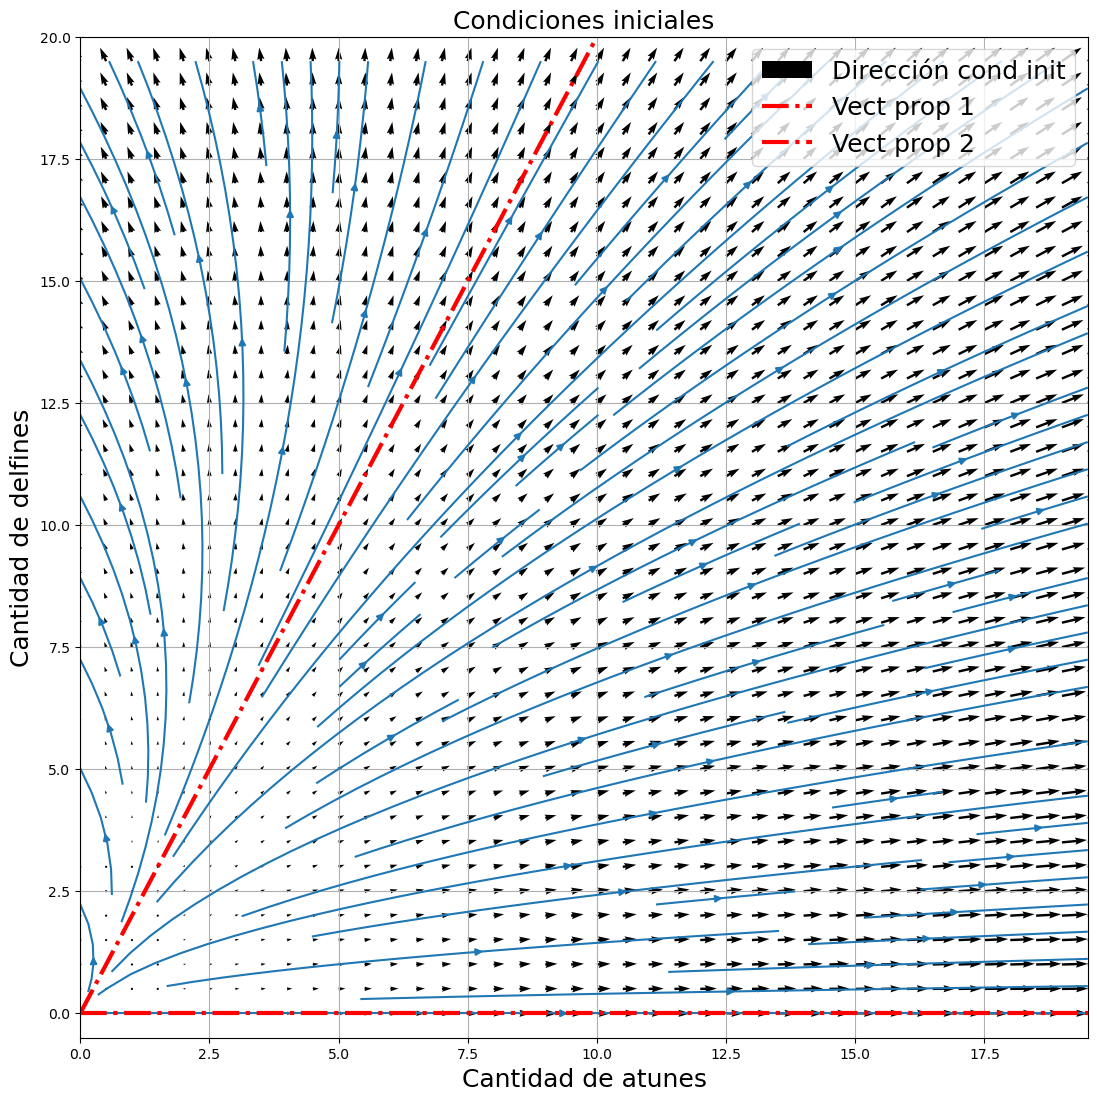

In [28]:
# Cantidades de las dos poblaciones a=atunes, d=delfines
A = np.arange(0, 20, 0.5)
D = np.arange(0, 20, 0.5)

# Rejilla de conodiciones iniciales
AA, DD = np.meshgrid(A, D)

# Inicialización del campo de vectores
U = np.empty_like(AA)
V = np.empty_like(DD)

for i in range(AA.shape[1]):
    for j in range(DD.shape[0]):
        y0 = np.array([AA[i, j], DD[i, j]])

        alpha, beta, gamma = (3.0, 1.0, 1.0)

        t = np.linspace(0.1, 10.0, 1000)

        dy1, dy2 = system_ode(y0, t, alpha, beta, gamma)

        U[i, j] = y0[0] + dy1
        V[i, j] = y0[1] + dy2

# Ploteando las soluciones
plt.figure(figsize=(13, 13))

# Campo de vectores
plt.quiver(AA, DD, U, V, label="Dirección cond init")

# Campo de flujo
plt.streamplot(AA, DD, U, V, density=1.2)

# Ploteando las lineas formadas por los vectores propios
plt.plot(A, np.zeros_like(A), "-.r", label="Vect prop 1", linewidth=3.0)
plt.plot(A, A * 2.0, "-.r", label="Vect prop 2", linewidth=3.0)

plt.grid()

plt.xlabel("Cantidad de atunes", fontsize=18)
plt.ylabel("Cantidad de delfines", fontsize=18)

plt.xlim(left=0.0)
plt.ylim(top=20.0, bottom=-0.5)

plt.legend(loc="upper right", fontsize=18)

plt.title("Condiciones iniciales", fontsize=18)

plt.show()
plt.close()

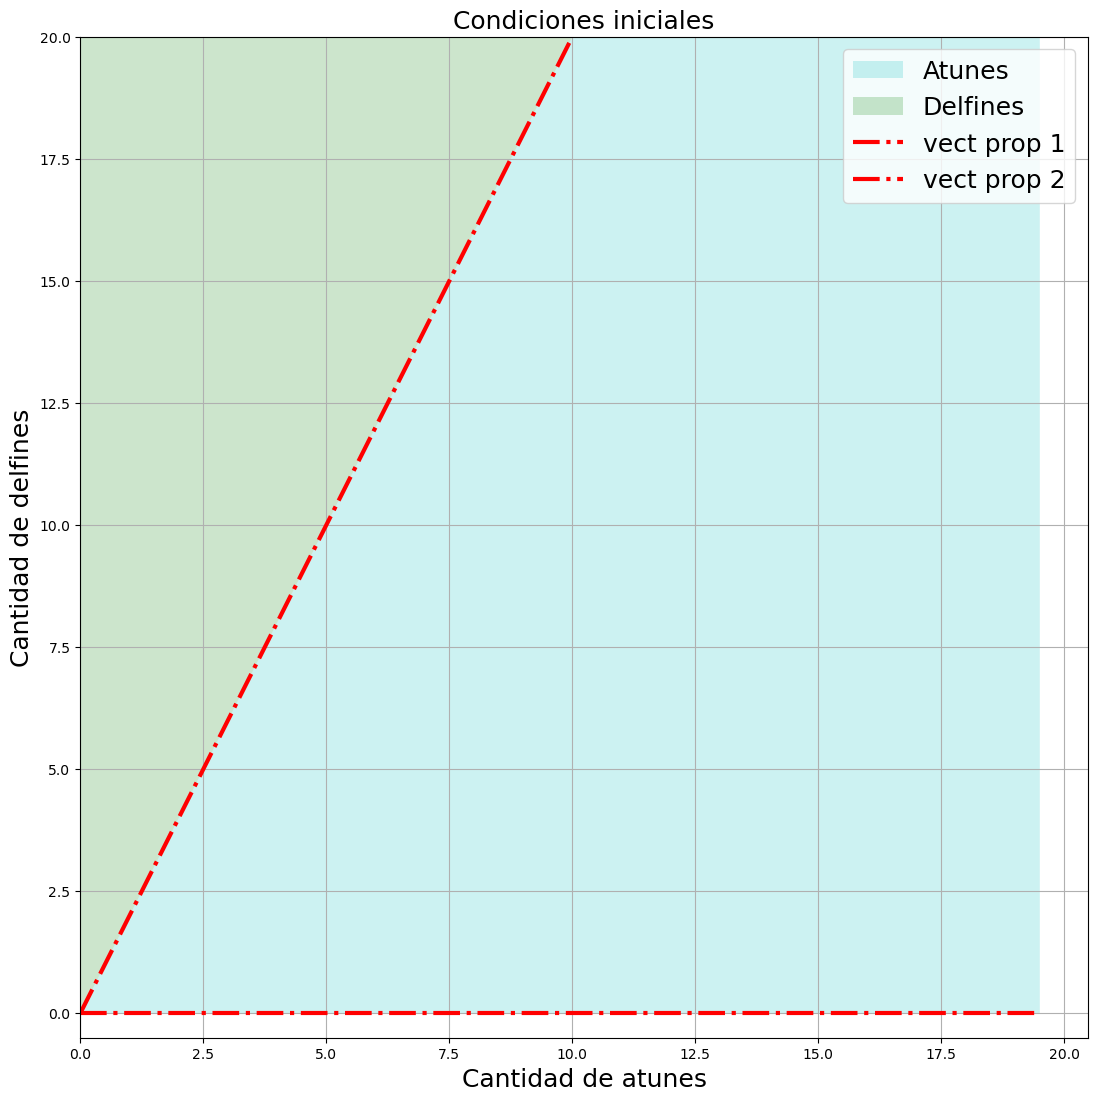

In [29]:
plt.figure(figsize=(13, 13))

# Ploteando las areas no balanceadas para Atunes y Delfines
plt.fill_between(A, A * 2.0, A * 0.0, facecolor="c", alpha=0.2, label="Atunes")
plt.fill_between(
    A, A * 2.0, np.full_like(A, 25.0), facecolor="g", alpha=0.2, label="Delfines"
)

plt.plot(A, np.zeros_like(A), "-.r", label="vect prop 1", linewidth=3.0)
plt.plot(A, A * 2.0, "-.r", label="vect prop 2", linewidth=3.0)

plt.grid()

plt.xlabel("Cantidad de atunes", fontsize=18)
plt.ylabel("Cantidad de delfines", fontsize=18)

plt.xlim(left=0.0)
plt.ylim(top=20.0, bottom=-0.5)

plt.legend(fontsize=18)

plt.title("Condiciones iniciales", fontsize=18)

plt.show()
plt.close()